# Redes neurais

* Grosso modo, redes neurais são funções $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$ com um determinado tipo de estrutura.

* Nesse ponto, não são diferentes de polinômios, cuja estrutura é a de combinação linear de monômios: $f(x) = a_0 + a_1x + \ldots + a_k x^k$. 

* Ou de polinômios senoidais, cuja estrutura é a de combinação linear de senos e/ou cossenos com frequências e fases variadas, como na série de Fourier: $f(t) = a_1\sin(\theta_1 + \omega_1 t) + \ldots + a_k\sin(\theta_k + \omega_k t)$.

* E de muitas outras classes de funções aproximantes (polinômios de Chebyshev, polinômios de Lagrange, aproximações de Padé por funções racionais, etc.)

* Uma das redes neurais mais simples que podemos considerar é a rede *pró-alimentada* de camadas *densas*, formada pela composição de funções da forma
$$
x \mapsto g(Wx + b),
$$
onde $g : \mathbb{R} \rightarrow \mathbb{R}$ é chamada de **função de ativação**, $W$ é uma matriz de **pesos** e $b$, de **viés**.

* Podemos ter $x$, $W$ e $b$ escalares, mas, em geral, $x$ e $b$ são vetores e $W$, uma matriz (ou tensores de maior dimensão). Nesse caso, $g$ age em cada elemento do vetor $Wx + b$, gerando um vetor de mesma dimensão.

* Há vários pacotes Julia para faciliar a construção e o treinamento de redes neurais. O mais conhecido e utilizado deles é o [Flux.jl](https://github.com/FluxML/Flux.jl).

In [49]:
using LinearAlgebra: ⋅
using Flux
using Plots
using ChainPlots

## Perceptron com dois sinais de entrada

* Vamos começar com um **percetron**, o *bloco-construtor* da rede neural de perceptrons originalmente proposta por [Frank Rosenblatt](https://en.wikipedia.org/wiki/Frank_Rosenblatt), nos anos 1950-1960.

* Pra começar, um **perceptron de duas entradas** é uma função que recebe dois sinais (valores) $x_1$ e $x_2$ e que, de acordo com **pesos** $w_1, w_2$ e de um **limiar** $r$, retorna um valor $0$ ou $1$.

* A regra associada a esses parâmetros é
$$
  \text{saída} = 
    \begin{cases}
      0, & \displaystyle \text{se } w_1x_1 + w_2x_2 \leq r, \\
      1, & \displaystyle \text{se }  w_1x_1 + w_2x_2 > r.
    \end{cases}
$$

* Ou seja, o *neurônio* é **ativado** se o sinal ponderado $w_1x_1 + w_2x_2$ está **acima do limiar**, caso contrário, ele não é ativado.

## Perceptrons com múltiplos sinais de entrada

* Isso pode ser generalizado para um número arbitrário de sinais de entrada $x_1,\ldots,x_n$, com pesos $w_1, \ldots, w_n$.

* E, atualmente, se usa $b=-r$, denominado **viés**, de forma que o sinal de saída fica sendo
$$
  \text{saída} = 
    \begin{cases}
      0, & \displaystyle \text{se } \sum_{i=1}^n w_ix_i + b \leq 0, \\
      1, & \displaystyle \text{se }  \sum_{i=1}^n w_ix_i + b > 0.
    \end{cases}
$$

* Isso pode ser escrito de uma forma mais compacta com uma **função de ativação**
$$ h(s) = \max\{0,\operatorname{sgn}(x)\} = \begin{cases} 1, & s>0 \\ 0, & s\leq 0 \end{cases}
$$

* E com um **matriz de pesos**
$$
W = \left[w_1 w_2 \ldots w_n\right] \in \mathbb{R}^{1 \times n}.
$$

* Assim,
$$ \text{saída} = h\left(w_1x_1 + \ldots + w_nx_n + b\right) = h\left(Wx + b\right).
$$

## Implementando um perceptron em Julia

* Um perceptron pode ser facilmente implementado em `julia`:

In [50]:
n = 2                      # número de entradas
W = [0.6 0.8]              # pesos
b = 1.0                    # viés
h(s) = ifelse(s > 0.0, 1.0, 0.0)   # função de ativação

l(x, h, W, b) = h.(W * x .+ b)         # perceptron

l (generic function with 1 method)

* Podemos aplicar `l` a escalares ou vetores e/ou matrizes.

In [51]:
l(2, h, 0.6, 1)

1.0

In [52]:
l([1, 2], h, [0.6 0.2], [2, 2])

2-element Vector{Float64}:
 1.0
 1.0

In [53]:
l([1 2; 3 4], h, [-1 1], [1; 2])

2×2 Matrix{Float64}:
 1.0  1.0
 1.0  1.0

* A função de ativação tem a forma de um "degrau":

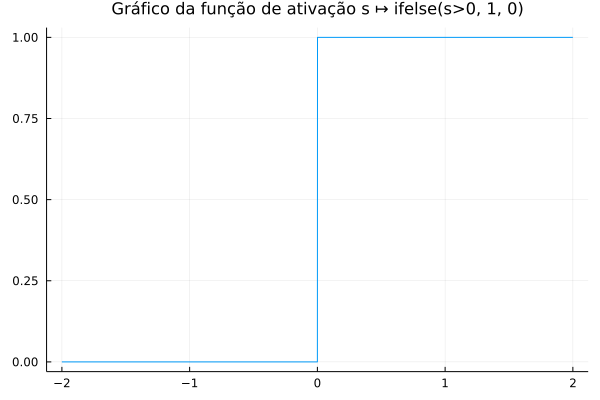

In [54]:
plot(-2:0.001:2, h, legend=false,
    title="Gráfico da função de ativação s ↦ ifelse(s>0, 1, 0)", titlefont=11)

* Com o peso ponderado, temos um comportamento "degrau" análogo, só que multi-dimensional:

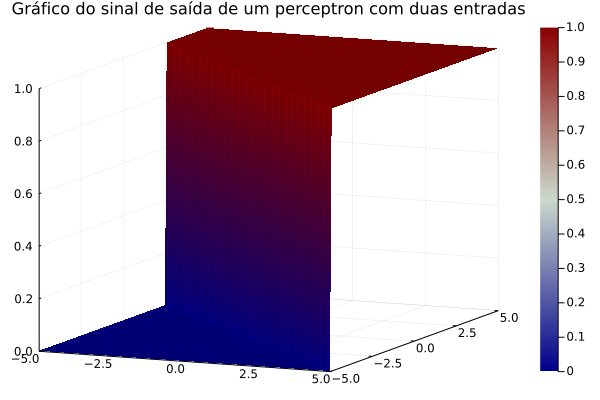

In [55]:
surface(-5:0.1:5, -5:0.1:5, (x,y) -> l([x,y], h, W, b)[1], c=:bluesreds,
    title="Gráfico do sinal de saída de um perceptron com duas entradas",
    titlefont=11)

## Redes de perceptrons.

* A função de ativação do perceptron é perfeita para representar circuitos digitais.
* De fato, redes de perceptrons podem ser estruturadas para fazer qualquer operação booleana (AND, NOT, OR, XOR, NAND, etc...)
* E junto com isso, qualquer operação aritmética binária (adição, subtração, multiplicação, divisão).
* Redes de perceptrons são obtidas encadeando-se diversos perceptrons como acima, com uma ou mais entradas.
* Mas isso deve ser construído explicitamente.
* Redes de perceptrons não são boas de se *treinar* (i.e. ajustar os parâmetros $W$ e $b$, ou outros em redes mais complexas)
* De fato, sendo a função de ativação constante por partes, o seu gradiente é nulo quase sempre, então não podemos utilizar métodos clássicos de otimização. Métodos livres de derivada funcionam, mas perde-se muito em eficiência, principalmente ao se treinar redes com dezenas, centenas, milhares, bilhões ou trilhões de parâmetros.
* Vale mencionar que o [Deep Blue](https://en.wikipedia.org/wiki/Deep_Blue_(chess_computer)), um sistema para jogar xadrez desenvolvido há quase trinta anos pela [IBM](https://en.wikipedia.org/wiki/IBM) e que venceu o grande campeão mundial [Garry Kasparov](https://en.wikipedia.org/wiki/Garry_Kasparov), possuia mais de oito mil parâmetros.
* Atualmente, há redes neurais com trilhões de parâmetros (e.g. [Mythbusting Google’s New Trillion-Parameter AI Language Model](https://www.hyro.ai/post/mythbusting-googles-new-trillion-parameter-ai-language-model)).
* Para resolver isso, precisamos de funções de ativação suaves.

## Outras funções de ativação

* Há várias outras funções de ativação comumente utilizadas, com as características de
    * ser suave;
    * variar entre um sinal de saída "baixo" e um "alto"."
* Podemos definir essas funções explicitamente, ou pegar emprestado diretamente do `Flux.jl`.
* Aqui a lista de [funções de ativação](https://fluxml.ai/Flux.jl/stable/models/nnlib/#Activation-Functions-1) definidas no pacote [FluxML/NNlib.jl](https://github.com/FluxML/NNlib.jl) e utilizadas (reexportadas) pelo `Flux.jl`.
* Podemos acessar os códigos de implementação dessas funções de ativação em [NNlib.jl/src/activations.jl](https://github.com/FluxML/NNlib.jl/blob/master/src/activations.jl).
* A lista delas está acessível na constante `NNlib.ACTIVATIONS`:

In [56]:
NNlib.ACTIVATIONS

24-element Vector{Symbol}:
 :σ
 :hardσ
 :hardtanh
 :relu
 :leakyrelu
 :relu6
 :rrelu
 :elu
 :gelu
 :swish
 ⋮
 :logσ
 :logcosh
 :mish
 :tanhshrink
 :softshrink
 :trelu
 :lisht
 :tanh_fast
 :sigmoid_fast

* Uma das mais conhecidas é a sigmoid:
$$ σ(x) = \frac{1}{1 + \exp(-x)}.
$$

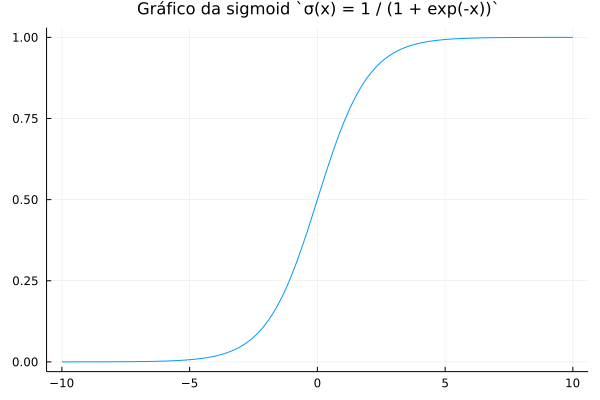

In [57]:
plot(-10:0.1:10, NNlib.σ, legend=false,
    title="Gráfico da sigmoid `σ(x) = 1 / (1 + exp(-x))`", titlefont=11)

## Visualizando todas as funções de ativação

In [58]:
ativacoes = hcat([getproperty(NNlib, ativacao).(-10:0.1:10) for ativacao in NNlib.ACTIVATIONS[1:end]]...)
nothing

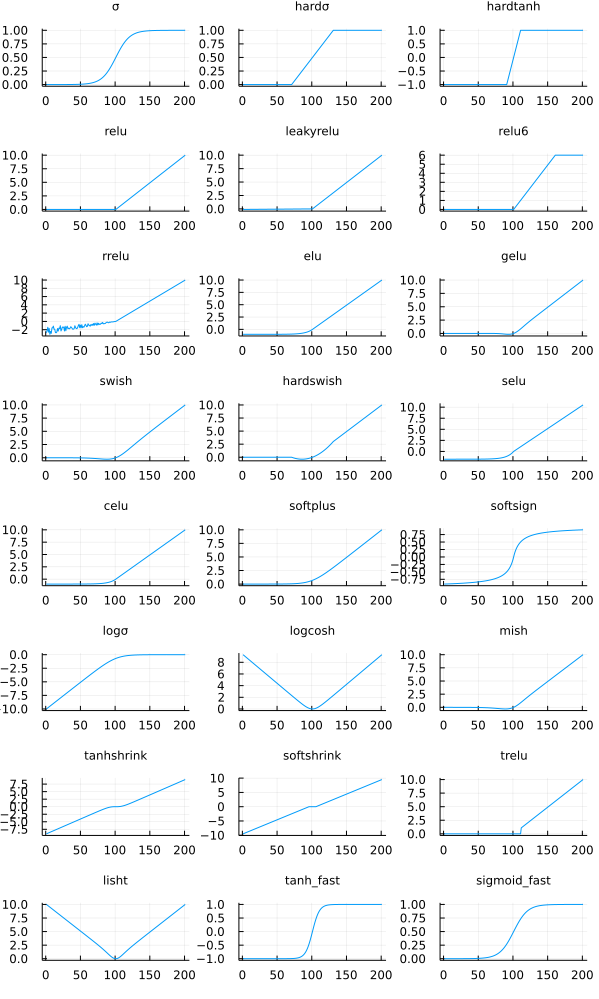

In [59]:
ncols = 3
nlinhas = divrem(length(NNlib.ACTIVATIONS), ncols) |> drn -> drn[1] + sign(drn[2])
plot(ativacoes, layout = grid(nlinhas, ncols), legend=false, size=(600,1000),
    title=hcat(NNlib.ACTIVATIONS...), titlefont=8)

## Outros neurônios

* Podemos compor uma função de ativação $f:\mathbb{R}\rightarrow \mathbb{R}$ qualquer...

* ... com a média ponderada $w_1x_1 + \ldots + w_nx_n$ dos sinais de entrada ...

* ... para formar um neurônio
$$ (x_1, \ldots, x_n) \mapsto f(w_1x_1 + \ldots + w_nx_n).
$$

* Isso pode ser feito explicitamente como acima.

* Ou com o `Dense()` do `Flux.jl`.

In [60]:
n = 2
m = Dense(n, 1)

Dense(2 => 1)       # 3 parameters

## Visualização da rede

* A visualização dessa rede pode ser feita com o pacote [ChainPlots.jl](https://github.com/rmsrosa/ChainPlots.jl).

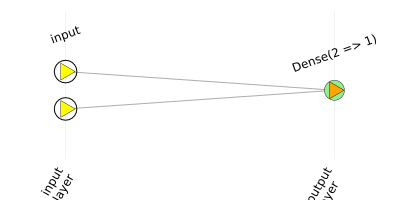

In [61]:
plot(m, size=(400, 200))

## Sobre o `Dense`

* `Dense` é um conjunto de "coisas", de acordo com a filosofia de *múltiplo despachos* do julia.

* `Dense` é um **struct** (ou "tipo composto"), que armazena uma *matriz de pesos*, o *viés* e *função de ativação*, representando, assim, um tipo de neurônio.

* `Dense` são vários **inner and outer constructors** (ou "construtores internos e externos"), que servem para criar uma instância do *struct* `Dense` de maneiras diferentes.

* `Dense` também acarreta na definição de um método que "avalia" a ação de uma instância do struct nos sinais de entrada (a ação do neurônio em si).

In [62]:
fieldnames(Dense) # nomes dos campos do tipo composto 

(:weight, :bias, :σ)

In [63]:
methods(Dense) # métodos para a construção do tipo composto

# 7 methods for type constructor:
[1] Dense(in::Integer, out::Integer) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/deprecations.jl:63
[2] Dense(in::Integer, out::Integer, σ; kw...) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/deprecations.jl:63
[3] Dense(::Pair{<:Integer, <:Integer}) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:150
[4] Dense(::Pair{<:Integer, <:Integer}, σ; init, bias) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:150
[5] Dense(W::M) where M<:(AbstractMatrix) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:144
[6] Dense(W::M, bias) where M<:(AbstractMatrix) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:144
[7] Dense(W::M, bias, σ::F) where {M<:(AbstractMatrix), F} in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:144

In [64]:
methods(m) # métodos definidos 

# 2 methods:
[1] (a::Dense)(x::AbstractVecOrMat) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:157
[2] (a::Dense)(x::AbstractArray) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:162

In [65]:
methodswith(Dense)

[1] show(io::IO, l::Dense) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/basic.jl:165
[2] show(io::IO, m::MIME{Symbol("text/plain")}, x::Dense) in Flux at /Users/rrosa/.julia/packages/Flux/6Q5r4/src/layers/show.jl:61

In [83]:
show(Docs.doc(Dense))

```
Dense(in => out, σ=identity; bias=true, init=glorot_uniform)
Dense(W::AbstractMatrix, [bias, σ])
```

Create a traditional fully connected layer, whose forward pass is given by:

```
y = σ.(W * x .+ bias)
```

The input `x` should be a vector of length `in`, or batch of vectors represented as an `in × N` matrix, or any array with `size(x,1) == in`. The out `y` will be a vector  of length `out`, or a batch with `size(y) == (out, size(x)[2:end]...)`

Keyword `bias=false` will switch off trainable bias for the layer. The initialisation of the weight matrix is `W = init(out, in)`, calling the function given to keyword `init`, with default [`glorot_uniform`](@doc Flux.glorot_uniform). The weight matrix and/or the bias vector (of length `out`) may also be provided explicitly.

# Examples

```jldoctest
julia> d = Dense(5 => 2)
Dense(5 => 2)       # 12 parameters

julia> d(rand(Float32, 5, 64)) |> size
(2, 64)

julia> d(rand(Float32, 5, 1, 1, 64)) |> size  # treated as three batch dimensio

In [31]:
@which Dense(2,1)

Dense(in::Integer, out::Integer) in Flux at /Users/rmsrosa/.julia/packages/Flux/6Q5r4/src/deprecations.jl:63

* Código fonte para `Flux.Dense` em [src/basic.jl#L71](https://github.com/FluxML/Flux.jl/blob/master/src/layers/basic.jl#L71), no repositório do `Flux.jl`.

## Diferenças sobre a nossa implementação

* A nossa definição foi

```julia
l(x, h, W, b) = h.(W * x .+ b)
```

* A definição para uma instância do `Dense` é (obtido de [src/basic.jl#L71](https://github.com/FluxML/Flux.jl/blob/master/src/layers/basic.jl#L71))

```julia
function (a::Dense)(x::AbstractVecOrMat)
  W, b, σ = a.weight, a.bias, a.σ
  return σ.(W*x .+ b)
end
```

* **Observação:** No *struct* do dense, `σ` é o nome do campo que guarda a função de ativação do neurônio, que pode ser qualquer uma, não apenas a sigmóide `σ`, importada de `NNLib.σ`.

## Rede pró-alimentada

* Em uma rede pró-alimentada, concatenamos uma série de camadas densas.

* No `Flux.jl`, essa concatenação, ou composição, é feita com a função `Chain`.

In [85]:
m = Chain(Dense(2, 4, σ), Dense(4, 8, tanh), Dense(8, 1, relu))

Chain(
  Dense(2 => 4, σ),                     # 12 parameters
  Dense(4 => 8, tanh),                  # 40 parameters
  Dense(8 => 1, relu),                  # 9 parameters
)                   # Total: 6 arrays, 61 parameters, 628 bytes.

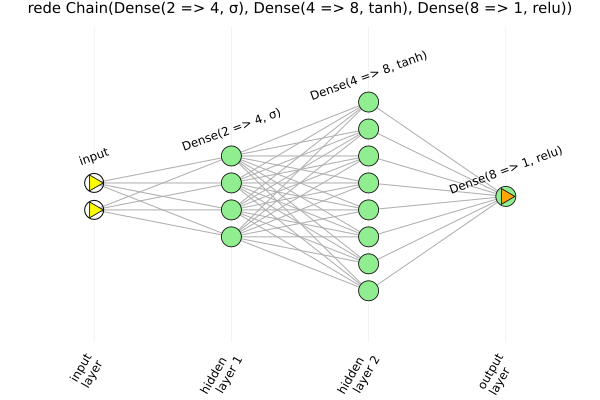

In [86]:
plot(m, title = "$m", titlefont = 10)

## Outros tipos de camadas

* Há vários tipos de camadas: recorrentes, convolucionais, *pooling*, etc.

* Cada uma com as suas aplicações.

* Redes recorrentes, por exemplo, guardam estados anteriores e são úteis onde a "história recente" de um dado é relevantes para o contexto, como em processamento de linguagem (e.g. palavras seguidas dando sentido a uma frase).

* Redes convolucionais fazem uma média ponderada de apenas algumas células vizinhas, importante quando as informações são localmente correlacionadas, como em processamento de imagens (e.g. uma imagem 2D onde cada pixel está, em geral, correlacionado a vários pixels vizinhos).

* Mas não vamos explorar isso a fundo. Isso é feito em cursos específicos de redes neurais. A ideia, aqui, é dar uma motivação geral e desmistificar um pouco isso.

* No próximo caderno, vamos nos concentrar em redes densas pró-alimentadas e fazer alguns ajustes de dados sintéticos.